<a href="https://colab.research.google.com/github/raghavendrapon/CodeAlpha_ProjectName/blob/main/TASK_2_Emotion_Recognition_from_Speech(using_LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
uwrfkaggler_ravdess_emotional_speech_audio_path = kagglehub.dataset_download('uwrfkaggler/ravdess-emotional-speech-audio')

print('Data source import complete.')


Data source import complete.


#  <center> Speech Emotion Recognition <center>

Datasets contains 8 types of emotions:

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np

import os
import sys
import random

# librosa is a Python library for analyzing audio and music.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
#from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.optimizers import Adam # Changed import to Adam
from keras.layers import Dropout

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Preparation
Creating a dataframe storing all emotions of the data in dataframe with their paths. I will use this dataframe to extract features for our model training.

In [ ]:
# Paths for data.
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_statement = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that auido.
        file_emotion.append(int(part[2]))
        file_statement.append(int(part[4]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
#emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
#path_df = pd.DataFrame(file_path, columns=['Path'])
#Ravdess_df = pd.concat([emotion_df, path_df], axis=1)
Ravdess_df = pd.DataFrame({"Emotions":file_emotion, "Statement":file_statement, "Path":file_path})

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

/tmp/ipython-input-4-117941219.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)


Emotions  Statement                                               Path
0  surprise          1  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral          1  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust          1  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust          1  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral          2  /kaggle/input/ravdess-emotional-speech-audio/a...

In [ ]:
Ravdess_df.shape

(1440, 3)

In [ ]:
Ravdess_df.groupby(['Emotions','Statement']).size().unstack()

Statement   1   2
Emotions         
angry      96  96
calm       96  96
disgust    96  96
fear       96  96
happy      96  96
neutral    48  48
sad        96  96
surprise   96  96

In [ ]:
# creating a copy
data_path = Ravdess_df[['Emotions','Path']].copy()
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...

## Data Visualisation and Exploration

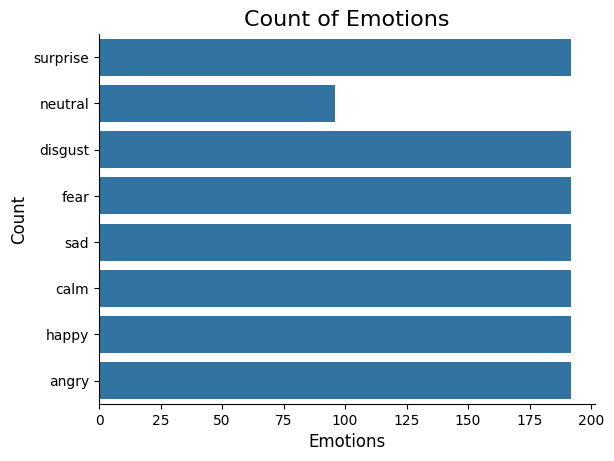

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Plotting waveplots and spectograms for audio signals.

In [ ]:
def create_waveplot(data, sr):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

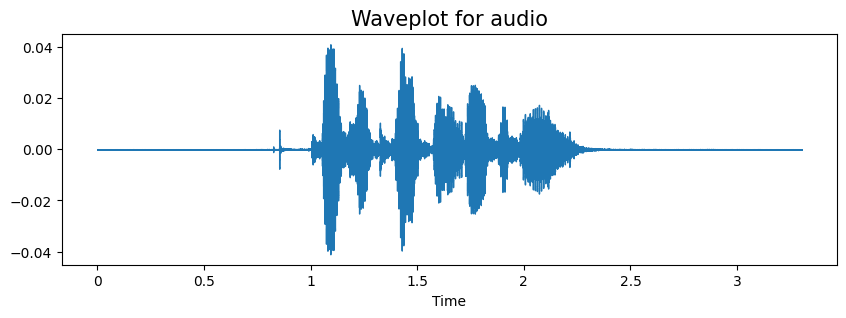

In [ ]:
path = "/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav"
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
Audio(path)

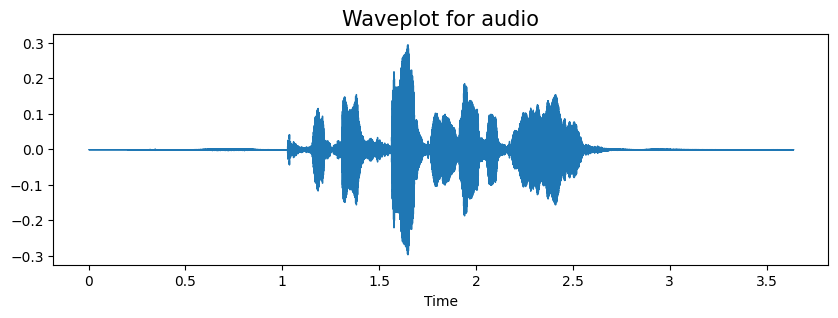

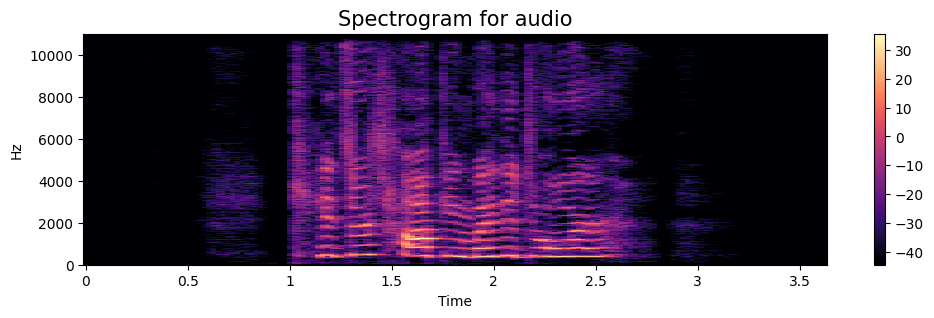

In [ ]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

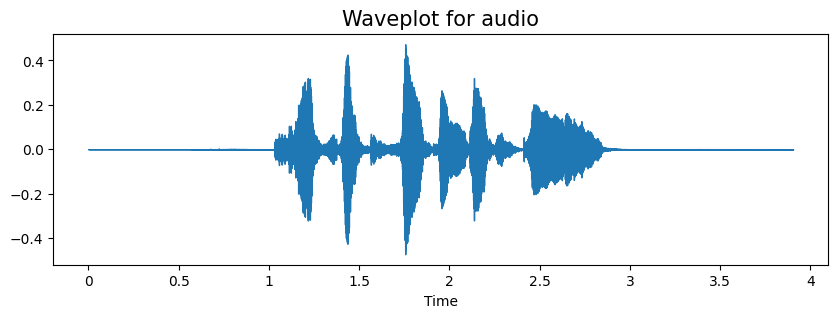

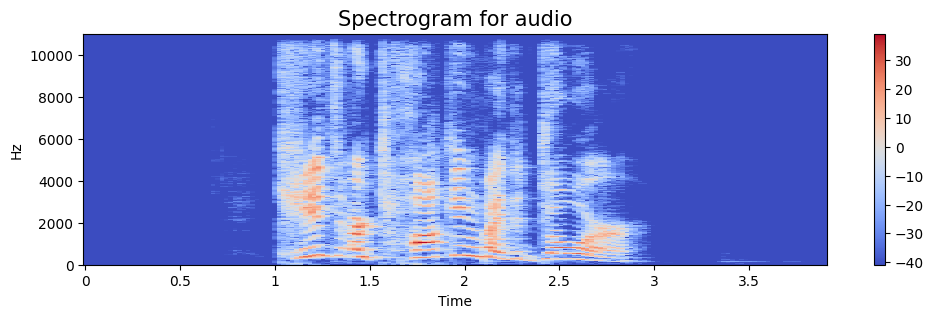

In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

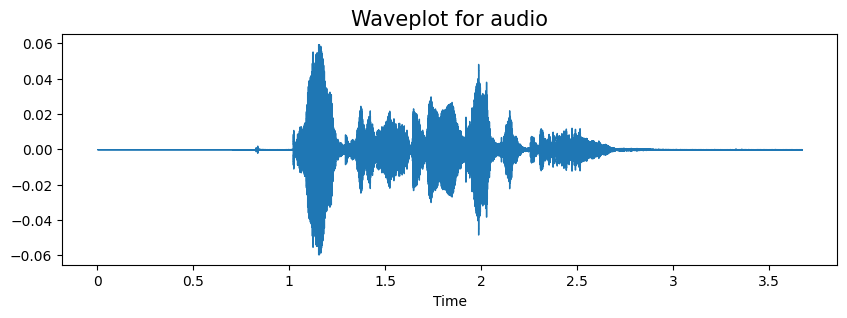

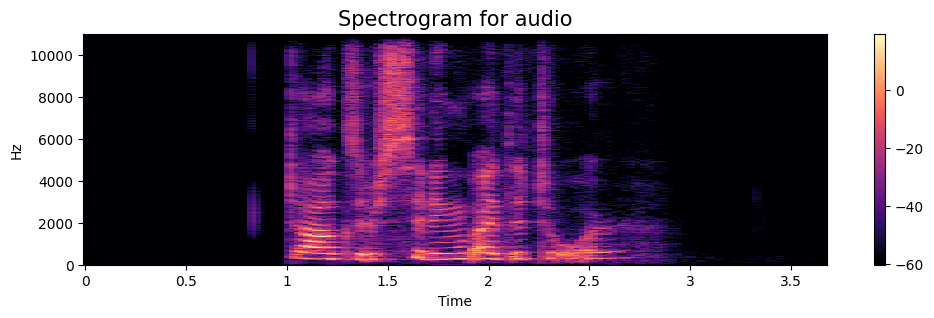

In [ ]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

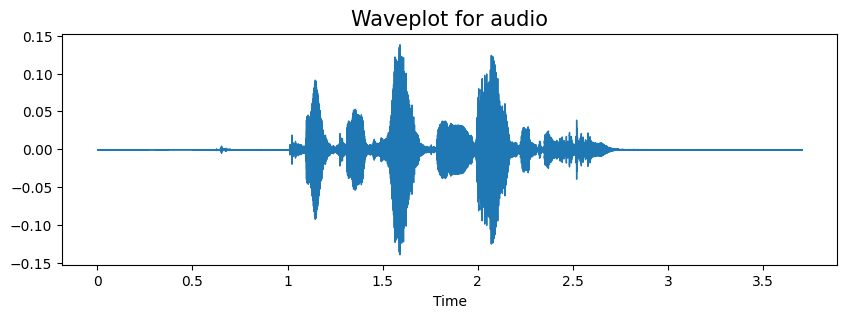

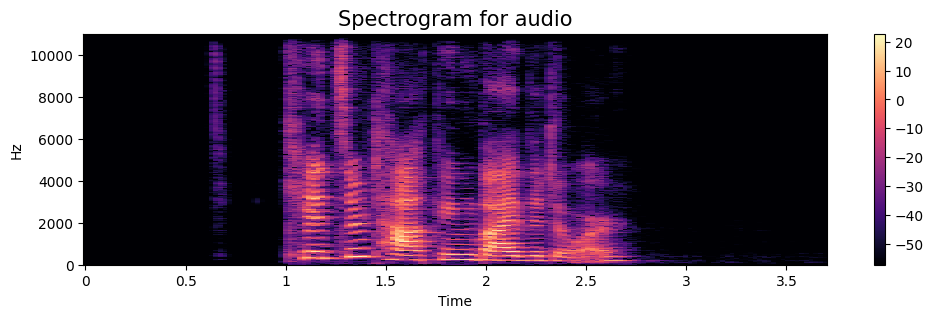

In [ ]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

## Data Augmentation

- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- Using Random transformations and augmenting data before training.

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.85):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

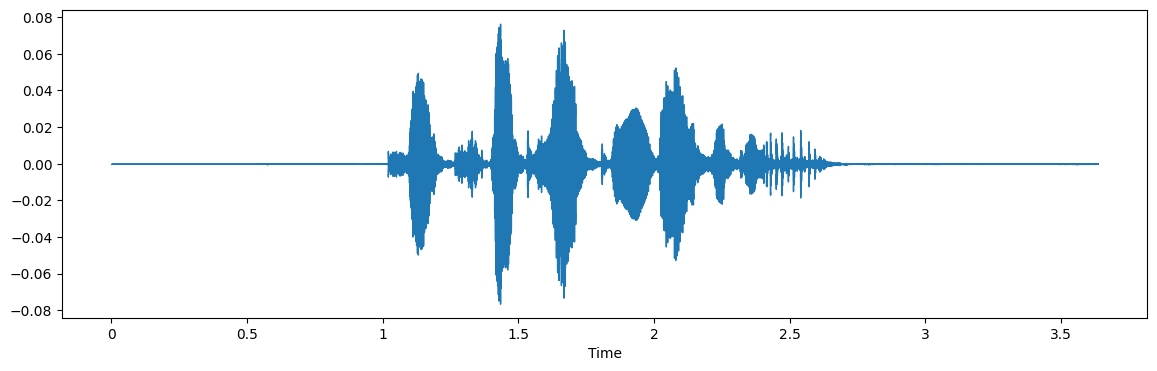

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

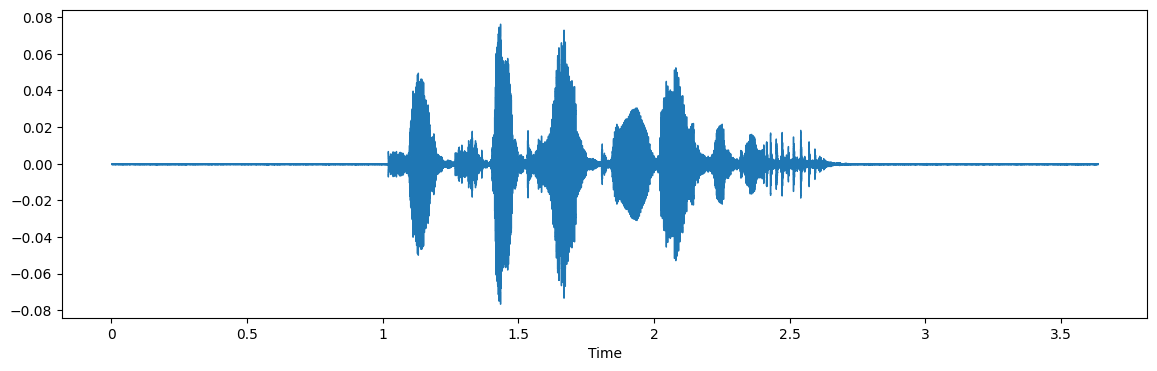

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 3. Stretching

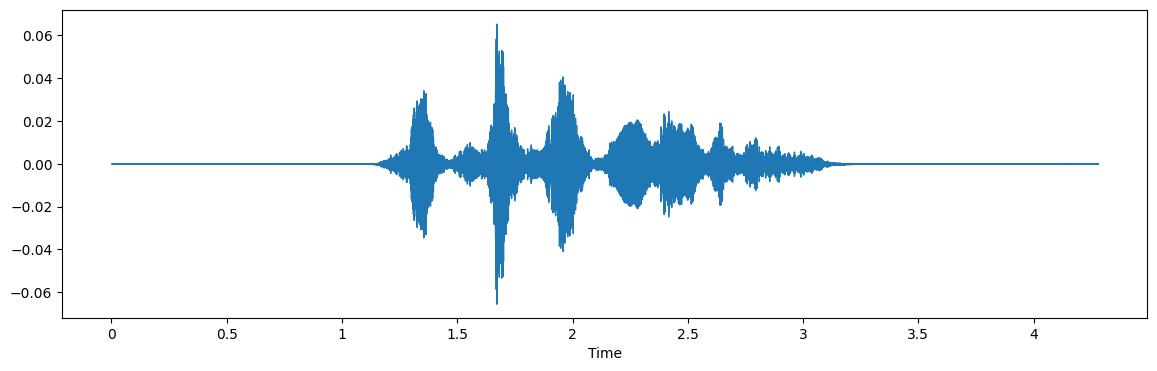

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

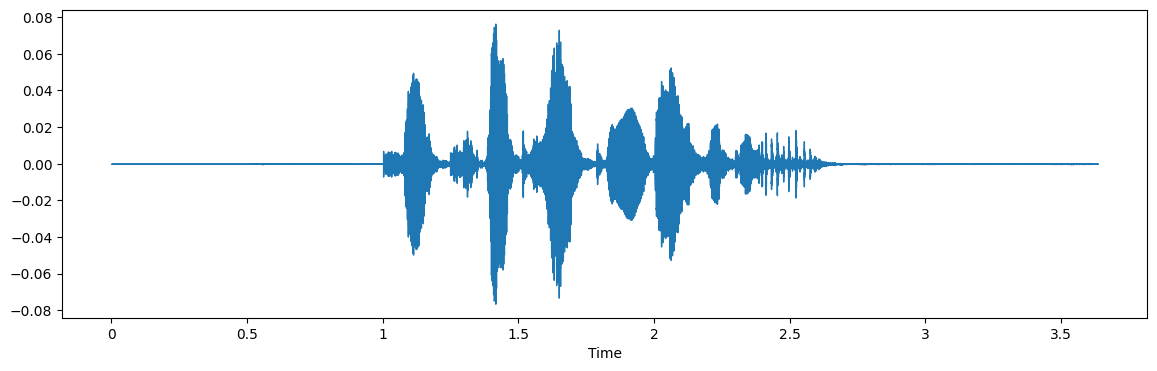

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

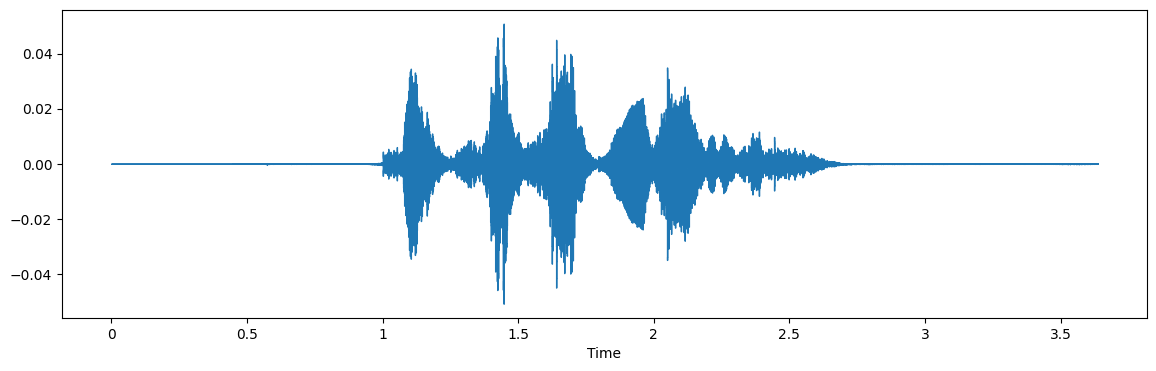

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Feature Extraction
With the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it. Extracting MFCC for the current experiment.

> MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

In [51]:
def extract_features(data):
    # MFCC
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate)
    result = mfcc
    return result

# funtion to transform audio
def transform_audio(data, fns):
    fn = random.choice(fns)
    if fn == pitch:
        fn_data = fn(data, sampling_rate)
    elif fn == "None":
        fn_data = data
    elif fn in [noise, stretch]:
        fn_data = fn(data)
    else:
        fn_data = data
    return fn_data


def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)


    #randomly transforming audio data
    fns = [noise, pitch, "None"]

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res1 = extract_features(fn2_data)
    result = [np.array(res1[:,:108])]

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res2 = extract_features(fn2_data)[:,:108]
    result.append(res2)#np.vstack((result, res2)) # stacking vertically

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res3 = extract_features(fn2_data)[:,:108]
    result.append(res3)#np.vstack((result, res3)) # stacking vertically

    return result

In [52]:
path = "/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav"
data, sampling_rate = librosa.load(path, duration=2.5, offset=0.6)
#create_waveplot(data, sampling_rate, emotion)
#create_spectrogram(data, sampling_rate, emotion)
Audio(path)
xx1 = librosa.feature.zero_crossing_rate(data)
stft = np.abs(librosa.stft(data))
xx2 = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
xx3 = librosa.feature.mfcc(y=data, sr=sample_rate)
xx4 = librosa.feature.rms(y=data)
xx5 = librosa.feature.melspectrogram(y=data, sr=sample_rate)
xx1.shape, xx2.shape, xx3.shape, xx4.shape, xx5.shape, np.append(xx1,xx2,axis=0).shape

#xx = extract_features(data)
#fns = [noise, stretch, pitch]
#xx1 = extract_features(stretch(data))
#xx.shape, xx1.shape
#xx = get_features(path)
#len(xx)

((1, 108), (12, 108), (20, 108), (1, 108), (128, 108), (13, 108))

In [53]:
X, Y = [], []
for path, emotion in zip(data_path.Path.to_list(), data_path.Emotions.to_list()):
    feature = get_features(path)
    for ele in feature:
        if ele.shape == (20, 108):
            X.append(ele)
            # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y.append(emotion)
        else:
            print(ele.shape)

(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 103)
(20, 103)
(20, 103)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 104)
(20, 104)
(20, 104)
(20, 101)
(20, 101)
(20, 101)
(20, 107)
(20, 107)
(20, 107)
(20, 105)
(20, 105)
(20, 105)
(20, 105)
(20, 105)
(20, 105)


In [54]:
len(X), len(Y), data_path.Path.shape

(4275, 4275, (1440,))

In [55]:
dfm = pd.DataFrame()
xx = pd.Series(X)
for i in range(20):
    dfm[i] = [k[i] for k in xx]

In [56]:
Features = dfm.copy()
Features['labels'] = Y
#Features.to_csv('features.csv', index=False)
Features.head()

0  \
0  [-389.9393715098316, -351.401130147385, -349.8...   
1  [-842.4295, -810.2739, -765.2346, -716.2717, -...   
2  [-414.789581535, -383.07277013197813, -393.400...   
3  [-696.5266219518567, -657.1164863458833, -657....   
4  [-597.1863994903342, -561.1032012236416, -557....   

                                                   1  \
0  [-4.369194419615592, -1.7352463826727582, -5.8...   
1  [-0.7284293, -20.485321, -34.117947, -35.37336...   
2  [-8.76310779137288, -5.372368891429332, -1.187...   
3  [-9.85627643791602, -7.959876122091989, -6.676...   
4  [-1.426082524128931, 1.5206362574704229, -1.39...   

                                                   2  \
0  [-1.0998155887610204, -1.495143042302637, -8.1...   
1  [1.1983405, 7.237005, 1.9692596, -12.551228, -...   
2  [-1.4533966339782602, -2.4993603676688623, -2....   
3  [2.5825232229790878, -1.1639851963923487, 0.67...   
4  [-8.1030781316483, -0.761259110182995, 2.00477...   

                                                   3  \
0  [-1.3435530721698348, 1.3802941277200342, -0.7...   
1  [0.1426451, 6.581012, 22.981255, 30.539558, 27...   
2  [9.732055869721602, 5.9078920591531485, 0.3495...   
3  [-0.0784792889556537, -0.2892640313321154, -0....   
4  [-5.619866689404914, -0.4321872592264205, 0.79...   

                                                   4  \
0  [6.324231504437494, 3.0813433071277387, 0.1132...   
1  [0.48735768, 4.3057284, 6.1818533, 5.2516675, ...   
2  [-1.5458901627954145, -3.0447290604645096, -3....   
3  [10.00713581906691, 3.6353528168498532, 1.0106...   
4  [-1.3411373529259587, -5.539882619201209, -7.7...   

                                                   5  \
0  [-1.3056825225584496, -0.4477451522761451, 1.6...   
1  [0.75797606, -3.726459, -11.300945, -17.780737...   
2  [0.8380251612425137, -3.2616738376946426, -1.4...   
3  [1.2576244853020508, -0.6971588461125829, -1.1...   
4  [-1.102806716875394, -6.346593161358157, -6.29...   

                                                   6  \
0  [0.3144383940316811, -0.7617052295187925, -0.5...   
1  [-0.13366777, -6.159712, -17.497791, -22.88784...   
2  [-2.0379761122391913, -3.7069306086991087, -7....   
3  [-2.447473240983494, 1.8028672857202388, 0.517...   
4  [-3.4225169194927876, -5.28821293590935, -4.39...   

                                                   7  \
0  [-10.234201390852323, -2.4605947933885286, 1.6...   
1  [1.1578127, 5.270331, 5.7176647, 7.7663975, 8....   
2  [-0.09331990706012938, -0.9528918982265417, 0....   
3  [-2.283789838897687, 0.72220068211725, 2.45479...   
4  [-0.7058245677265937, -1.8510123649778603, 1.1...   

                                                   8  \
0  [-5.190777228008164, 0.357723038506993, 2.8745...   
1  [-0.055297278, 0.74627936, 5.0191517, 10.54898...   
2  [2.1623794492409587, 3.329829819328836, -0.059...   
3  [-0.5702113387450106, 2.137485820963246, 1.917...   
4  [-1.4484769847764722, -2.1622624611188423, 0.2...   

                                                   9  ...  \
0  [-3.2907363350749277, -0.5971779164166332, 0.2...  ...   
1  [0.7435681, -0.7635658, -3.2766042, 0.44838846...  ...   
2  [8.479207600813584, 8.715980704768747, 4.06170...  ...   
3  [1.2316852596176244, -0.4367777255415921, -2.0...  ...   
4  [5.564958817983372, 6.424286373609144, 2.22120...  ...   

                                                  11  \
0  [-0.28895932764477084, -2.6554182889099858, -1...   
1  [0.581871, 7.5569496, 14.242103, 13.218212, 10...   
2  [4.526558711153559, 5.989852942315837, 2.35611...   
3  [2.217139823762739, 1.4621356852178922, 0.8787...   
4  [1.768888734449411, -2.8177504232084725, -3.24...   

                                                  12  \
0  [3.4334954893388643, 1.3407222918764714, 0.441...   
1  [0.44830012, 7.5226946, 14.02314, 17.73445, 20...   
2  [2.0079925288371694, 3.6233656665771408, 3.388...   
3  [4.286761715583976, 2.7852696430936055, 2.6615...   
4  [-0.5229383578645435, -1.549136

In [57]:
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((4275, 20, 108), (4275,))

## Data Preparation

In [58]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [59]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3420, 20, 108), (3420, 8), (855, 20, 108), (855, 8))

In [60]:
# making data compatible to model.
# Original shape of X is (4275, 20, 108)
# We want (batch_size, time_steps, features, 1, 1) for TimeDistributed(Conv2D)
# Let's reshape X to (batch_size, time_steps, features) first
X = X.swapaxes(1, 2) # Shape becomes (4275, 108, 20)

# Now split data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21, shuffle=True)

# Add the extra dimensions for Conv2D
x_train = np.expand_dims(x_train, axis=-1)
x_train = np.expand_dims(x_train, axis=-1)

x_test = np.expand_dims(x_test, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)


x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3420, 108, 20, 1, 1), (3420, 8), (855, 108, 20, 1, 1), (855, 8))

## Modelling

In [61]:
input_shape = x_train.shape[1:]
input_shape #(108, 162, 1, 1)

(108, 20, 1, 1)

In [62]:
model=Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 1), padding='same', activation='relu'),
                            input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,1))))

model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(Dense(32, activation='relu'))) # Add TimeDistributed Dense layer
model.add(LSTM(32))
model.add(Dropout(0.2))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=8, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_15             │ (None, 108, 20, 1, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 108, 20, 1, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 108, 10, 1, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 108, 160)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 108, 32)        │         5,152 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,920 (58.28 KB)

 Trainable params: 14,888 (58.16 KB)

 Non-trainable params: 32 (128.00 B)

In [64]:
from keras.optimizers import Adam
optimizer = Adam()
model.compile(optimizer=optimizer,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=4, min_lr=0.0000001)

epochs = 100
history = model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.1420 - loss: 2.1007 - val_accuracy: 0.1953 - val_loss: 2.0157 - learning_rate: 0.0010
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.1725 - loss: 2.0216 - val_accuracy: 0.1930 - val_loss: 1.9961 - learning_rate: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.2079 - loss: 1.9905 - val_accuracy: 0.2421 - val_loss: 1.9503 - learning_rate: 0.0010
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.2193 - loss: 1.9516 - val_accuracy: 0.2550 - val_loss: 1.8833 - learning_rate: 0.0010
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.2455 - loss: 1.8985 - val_accuracy: 0.3029 - val_loss: 1.8155 - learning_rate: 0.0010
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.2611 - loss: 1.9174 - val_accuracy: 0.3368 - val_loss: 1.7682 - learning_rate: 0.0010
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.2997 - loss: 1.7708 - val_ac

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.5794 - loss: 1.1790
Accuracy of our model on test data :  61.520469188690186 %


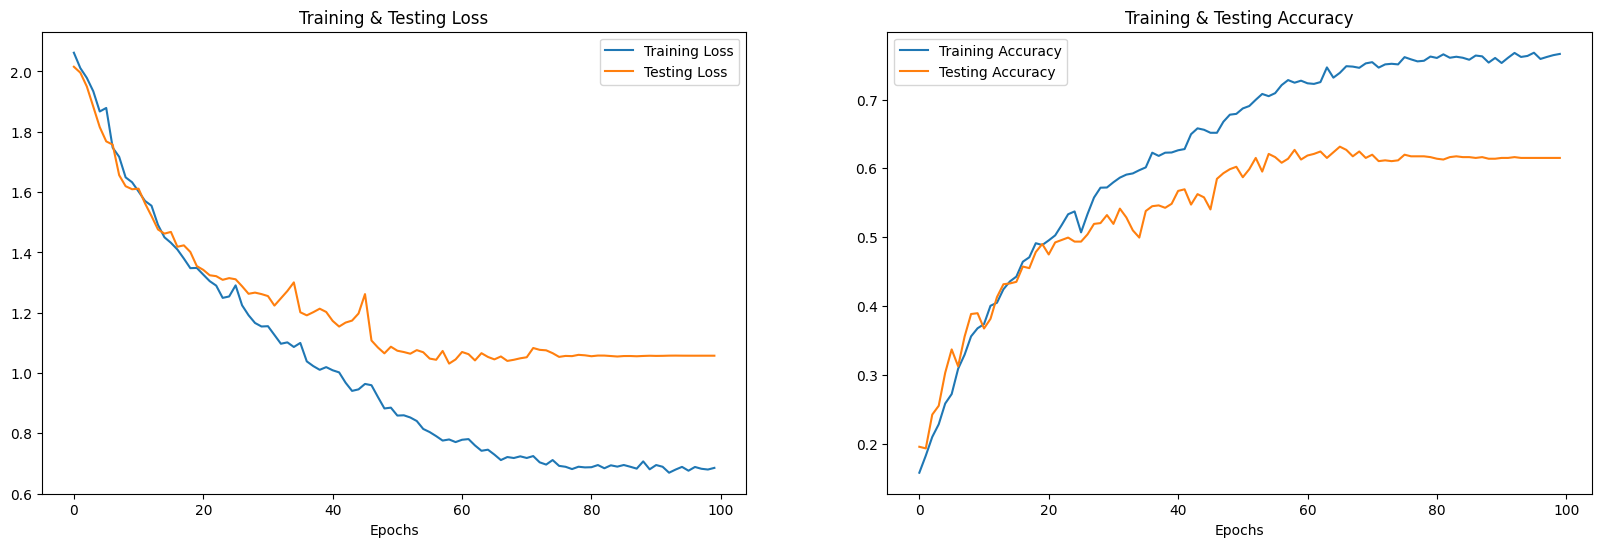

In [65]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [66]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 371ms/step


In [67]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0         surprise      surprise
1              sad       disgust
2            angry         angry
3            angry         angry
4         surprise      surprise
5         surprise         happy
6             fear          fear
7            happy         happy
8          neutral       neutral
9          disgust       disgust

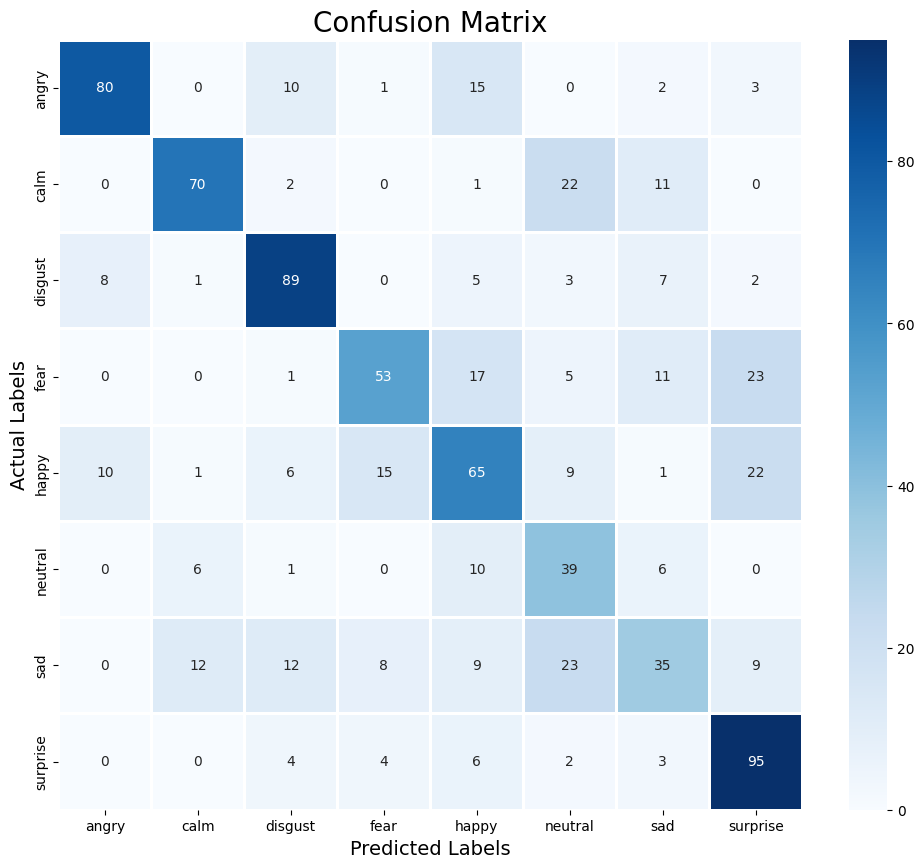

In [68]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.82      0.72      0.77       111
        calm       0.78      0.66      0.71       106
     disgust       0.71      0.77      0.74       115
        fear       0.65      0.48      0.55       110
       happy       0.51      0.50      0.51       129
     neutral       0.38      0.63      0.47        62
         sad       0.46      0.32      0.38       108
    surprise       0.62      0.83      0.71       114

    accuracy                           0.62       855
   macro avg       0.62      0.62      0.61       855
weighted avg       0.63      0.62      0.61       855



- Obtained is an acceptalbe model but poorly regularised. There is a clear case of overfitting here.
- Model is more accurate in predicting surprise, angry and calm emotions as audio corresponding to these emotions are much different to other emotions in a lot of ways like pitch, speed etc..
- Ooverall 65% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.
- Perhaps, better augmentation, realtime/on the go data augmentation could have produced a more regularised result.
- Different architectures and normalization methods can also be explored.